## 1. Importing libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [27]:
import lifelines

In [2]:
## Get Data
df = pd.read_csv("stanford_heart_transplant_dataset_full.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PATIENT_ID                   103 non-null    int64  
 1   YR_OF_ACCEPTANCE             103 non-null    int64  
 2   AGE                          103 non-null    int64  
 3   SURVIVAL_STATUS              103 non-null    int64  
 4   SURVIVAL_TIME                103 non-null    int64  
 5   PRIOR_SURGERY                103 non-null    int64  
 6   TRANSPLANT_STATUS            103 non-null    int64  
 7   WAITING_TIME_FOR_TRANSPLANT  69 non-null     float64
 8   MISMATCH_ON_ALLELES          69 non-null     float64
 9   MISMATCH_ON_ANTIGEN          69 non-null     float64
 10  MISMATCH_SCORE               43 non-null     float64
dtypes: float64(4), int64(7)
memory usage: 9.0 KB


In [3]:
df.head(5)

,PATIENT_ID,YR_OF_ACCEPTANCE,AGE,SURVIVAL_STATUS,SURVIVAL_TIME,PRIOR_SURGERY,TRANSPLANT_STATUS,WAITING_TIME_FOR_TRANSPLANT,MISMATCH_ON_ALLELES,MISMATCH_ON_ANTIGEN,MISMATCH_SCORE
0,15,68,53,1,1,0,0,NaN,NaN,NaN,NaN
1,43,70,43,1,2,0,0,NaN,NaN,NaN,NaN
2,61,71,52,1,2,0,0,NaN,NaN,NaN,NaN
3,75,72,52,1,2,0,0,NaN,NaN,NaN,NaN
4,6,68,54,1,3,0,0,NaN,NaN,NaN,NaN


In [5]:
df.AGE.value_counts().sort_index()

AGE
8      1
19     1
20     2
23     1
26     2
28     1
29     2
30     2
32     1
33     1
35     1
36     3
38     1
39     2
40     4
41     5
42     4
43     4
44     2
45     4
46     2
47    11
48     8
49     4
50     3
51     4
52     7
53     7
54     5
55     1
56     3
58     1
59     1
61     1
64     1
Name: count, dtype: int64

In [8]:
df.groupby("SURVIVAL_TIME").SURVIVAL_STATUS.value_counts()

SURVIVAL_TIME  SURVIVAL_STATUS
1              1                  1
2              1                  3
3              1                  3
5              1                  2
6              1                  2
                                 ..
1400           0                  1
1407           0                  1
1571           0                  1
1586           0                  1
1799           0                  1
Name: count, Length: 90, dtype: int64

## Model Fitting

### Agnostic to boolean variable: have/ haven't had prior heart surgery

In [10]:
kmf = KaplanMeierFitter(label='Stanford heart transplant dataset')
kmf?

Type:        KaplanMeierFitter
String form: <lifelines.KaplanMeierFitter>
File:        ~/Desktop/Projects/.venv/lib/python3.8/site-packages/lifelines/fitters/kaplan_meier_fitter.py
Docstring:  
Class for fitting the Kaplan-Meier estimate for the survival function.

Parameters
----------
alpha: float, optional (default=0.05)
    The alpha value associated with the confidence intervals.
label: string, optional
    Provide a new label for the estimate - useful if looking at many groups.

Examples
--------
.. code:: python

    from lifelines import KaplanMeierFitter
    from lifelines.datasets import load_waltons
    waltons = load_waltons()

    kmf = KaplanMeierFitter(label="waltons_data")
    kmf.fit(waltons['T'], waltons['E'])
    kmf.plot()


Attributes
----------
survival_function_ : DataFrame
    The estimated survival function (with custom timeline if provided)
median_survival_time_ : float
    The estimated median time to event. np.inf if doesn't exist.
confidence_interval_ : Dat

Text(0, 0.5, 'Survival probability')

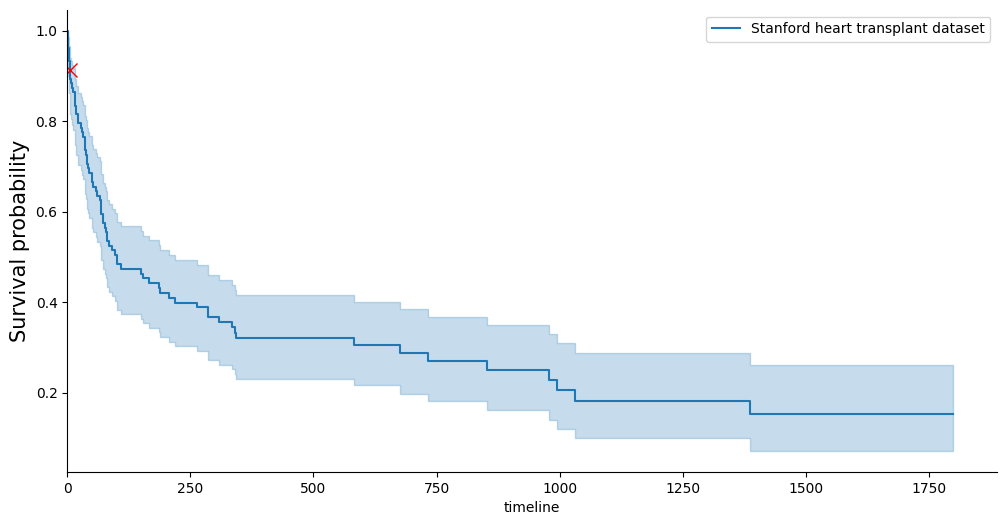

In [23]:
kmf = kmf.fit(durations=df['SURVIVAL_TIME'], event_observed=df['SURVIVAL_STATUS'])
predict_val = kmf.predict(6)

fig, ax = plt.subplots(figsize=(12,6))
ax = kmf.plot()
ax.plot(6, 0.9126, color='red', marker='x', markeredgewidth=1, markersize=10)
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Survival probability", fontsize=15)

### Sensitive to the prior surgery

In [24]:
idx = df['PRIOR_SURGERY'] == 1

In [25]:
kmf_w_prior_surgery = KaplanMeierFitter(label='Group with prior heart surgery').fit(
    durations=df[idx]['SURVIVAL_TIME'], event_observed=df[idx]['SURVIVAL_STATUS'])

kmf_wo_prior_surgery = KaplanMeierFitter(label='Group with prior heart surgery').fit(
    durations=df[~idx]['SURVIVAL_TIME'], event_observed=df[~idx]['SURVIVAL_STATUS'])

Text(0, 0.5, 'Survival probability')

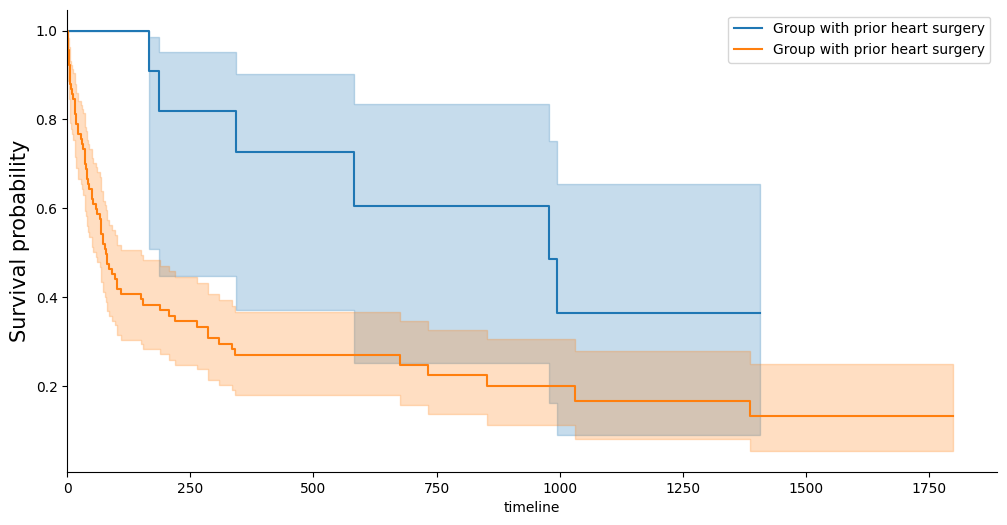

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax = kmf_w_prior_surgery.plot()
ax = kmf_wo_prior_surgery.plot()
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Survival probability", fontsize=15)



In [31]:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test?

Signature:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test(
    point_in_time,
    fitterA,
    fitterB,
    **result_kwargs,
) -> lifelines.statistics.StatisticalResult
Docstring:
Often analysts want to compare the survival-ness of groups at specific times, rather than comparing the entire survival curves against each other.
For example, analysts may be interested in 5-year survival. Statistically comparing the naive Kaplan-Meier points at a specific time
actually has reduced power (see [1]). By transforming the survival function, we can recover more power. This function uses
the log(-log(·)) transformation.


Parameters
----------
point_in_time: float,
    the point in time to analyze the survival curves at.

fitterA:
    A lifelines univariate model fitted to the data. This can be a ``KaplanMeierFitter``, ``WeibullFitter``, etc.

fitterB:
    the second lifelines model to compare against.

result_kwargs:
    add keywords and meta-data to the experiment summary



In [32]:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test(
    point_in_time=365,
    fitterA = kmf_w_prior_surgery,
    fitterB = kmf_wo_prior_surgery)

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 365
           fitterA = <lifelines.KaplanMeierFitter:"Group with prior heart surgery", fitted with 12 total observations, 6 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Group with prior heart surgery", fitted with 91 total observations, 22 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           5.65 0.02      5.84